In [242]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            50Gi       2.9Gi        28Gi       0.0Ki        19Gi        47Gi
Swap:             0B          0B          0B


In [210]:
!nvidia-smi

Wed Jan  3 17:19:54 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    38W / 300W |  10446MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [240]:
import pandas as pd
import os

def get_image_path(image_id:int):
    return os.path.join('../tiles_768', str(image_id))

train = pd.read_csv(f"../data/train.csv") # {'CC': 146576, 'EC': 165037, 'HGSC': 272477, 'LGSC': 46346, 'MC': 79036}
train = train[train['is_tma'] == True]
train['tile_path'] = train['image_id'].apply(lambda x: get_image_path(x))

def count_files_in_paths(df, label_column='label', path_column='tile_path'):
    # Group by the label column
    grouped = df.groupby(label_column)

    # Dictionary to store the sum of files for each label
    file_counts = {}

    # Iterating over each group
    for label, group in grouped:
        total_files = 0
        # Iterating over each path in the group
        for path in group[path_column]:
            if os.path.isdir(path):
                # Counting the number of files in the directory
                total_files += len([file for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))])
        
        file_counts[label] = total_files

    return file_counts

count_files_in_paths(train)

{'CC': 79, 'EC': 79, 'HGSC': 82, 'LGSC': 78, 'MC': 76}

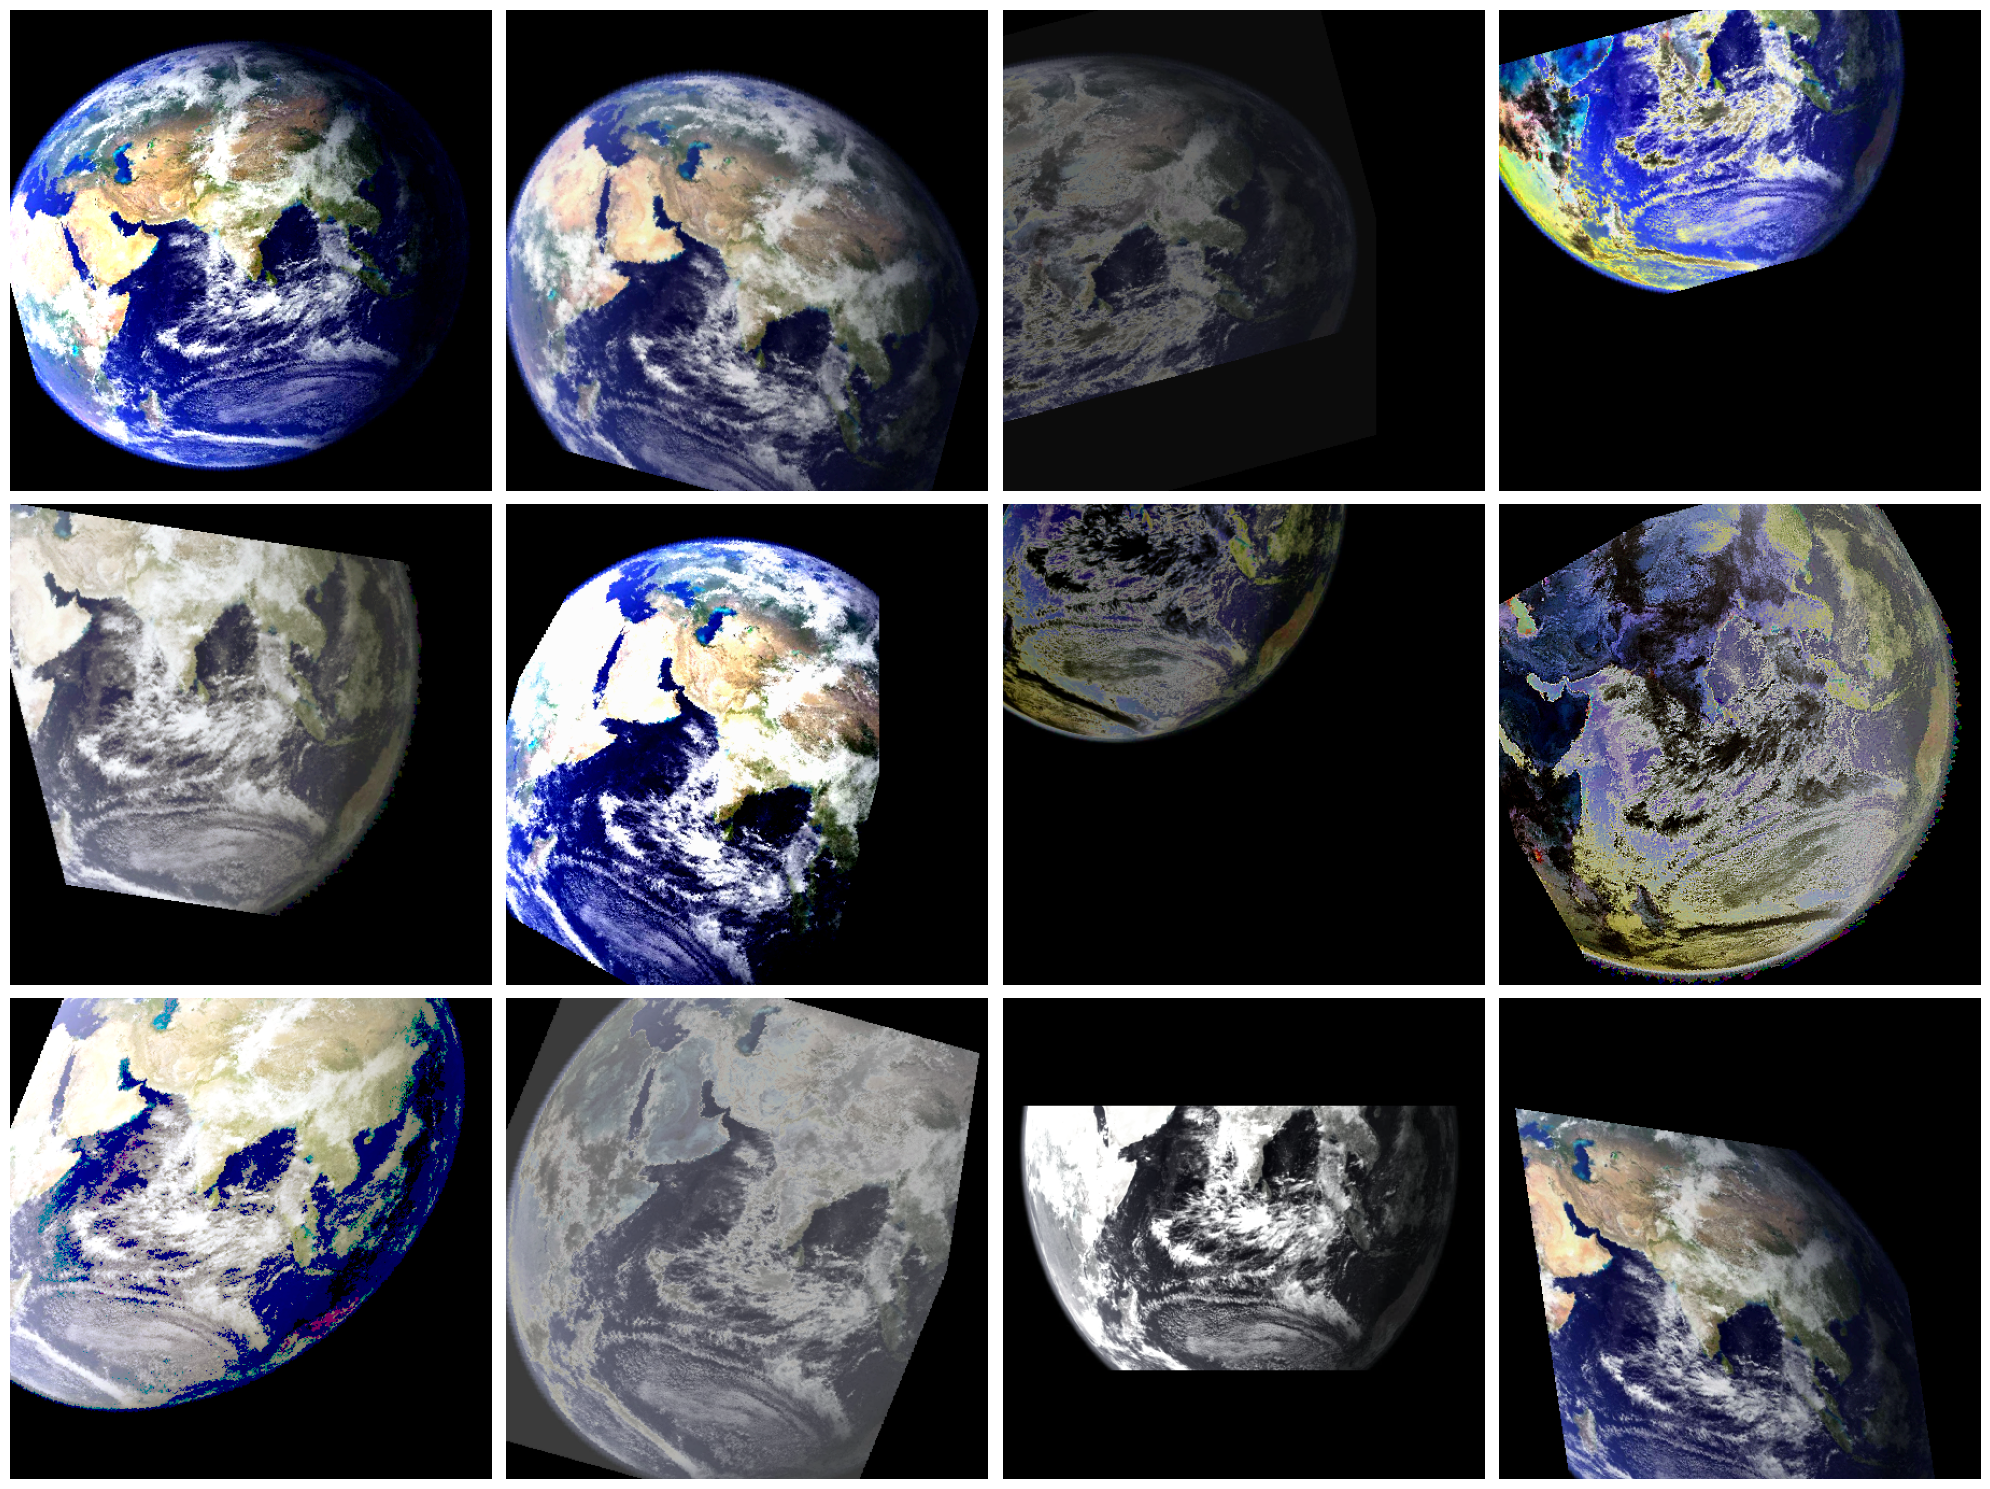

In [387]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
img_path = '../earth.jpeg'
image = Image.open(img_path)

# Define the RandAugment transform
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=448, scale=(0.5, 1.0), ratio=(0.75, 1.33)),
    transforms.RandAugment(9, 15, 31),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[
    #     0.48145466,
    #     0.4578275,
    #     0.40821073
    # ], std=[
    #     0.26862954,
    #     0.26130258,
    #     0.27577711
    # ]),
    # transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
    # transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
    # transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
    transforms.ToPILImage()
])

# Apply the transform to the image 12 times and plot
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

for i in range(12):
    ax = axs[i // 4, i % 4]
    transformed_image = transform(image)
    ax.imshow(transformed_image)
    ax.axis('off')

plt.tight_layout()
plt.show()

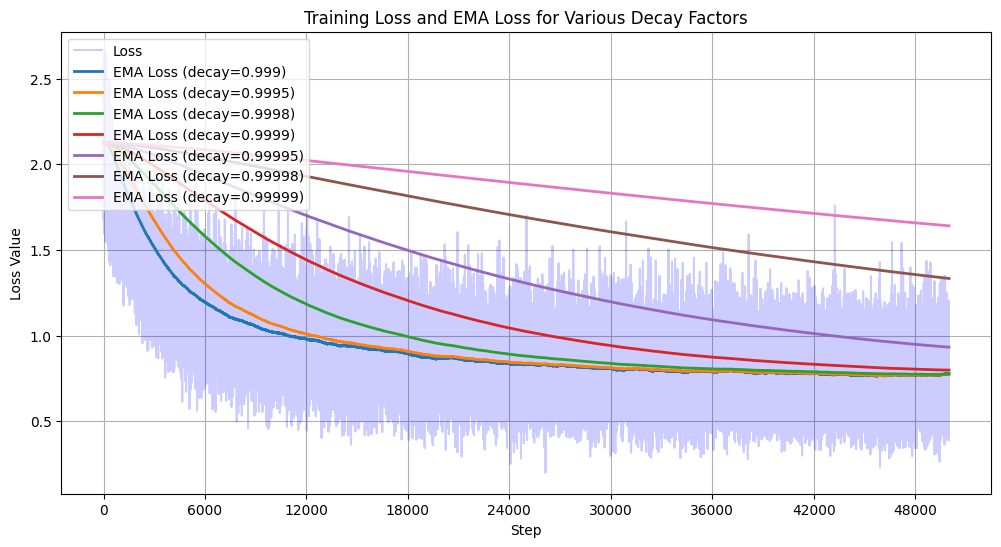

In [211]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def calculate_ema(values, alpha):
    ema_values = []
    ema = np.mean(values[:100])
    for i_value, value in enumerate(values):
        ema = alpha * ema + (1 - alpha) * value
        ema_values.append(ema)
    return ema_values

# Adjusted patterns to match the new log format
loss_pattern = re.compile(r'\[\d+, +(\d+)\] loss: ([\d.]+)')

# Lists to store the extracted data
steps = []
losses = []

# Model names and file paths for different training logs (commented for reference)
# MODEL_NAME = '20000_high_drop'
# MODEL_NAME = '20000_normal'
# MODEL_NAME = '25000_higher_dropout'
# MODEL_NAME = '25000_normal'
# MODEL_NAME = '50000'
# MODEL_NAME = '25000_cutmix_mixup'
# MODEL_NAME = 'cutmix_mixup_second_try'
# MODEL_NAME = 'cutmix_mixup_third_try'
# MODEL_NAME = 'cutmix_mixup_fourth_try'
# MODEL_NAME = 'cutmix_mixup_different_sampling'
# MODEL_NAME = 'cutmix_mixup_high_reg'
# MODEL_NAME = 'cutmix_mixup_different_sampling_high_lr'
# MODEL_NAME = 'cutmix_mixup_final_try_fold'
# MODEL_NAME = 'cutmix_mixup_final_try_all_the_data'
# MODEL_NAME = 'tma_special'
# MODEL_NAME = 'tma_special_pt_2'
MODEL_NAME = 'tma_from_start'
file_path = f'logs/eva02_base_train_{MODEL_NAME}.txt'  # Replace with the path to your file
# MODEL_NAME = 'first_try'
# MODEL_NAME = 'global_attention'
# MODEL_NAME = 'global_attention_higher_lr'
# MODEL_NAME = 'third_try'
# MODEL_NAME = 'global_attention_v2'
# file_path = f'logs/tinyvit_train_{MODEL_NAME}.txt'  # Replace with the path to your file
# MODEL_NAME = 'first_try'
# file_path = f'logs/coatnet_train_{MODEL_NAME}.txt'  # Replace with the path to your file

with open(file_path, 'r') as file:
    training_log = file.readlines()

# Parsing the file
for line in training_log:
    loss_match = loss_pattern.match(line)
    if loss_match:
        step, loss = map(float, loss_match.groups())
        steps.append(step)
        losses.append(loss)

# Creating DataFrame
loss_data = pd.DataFrame({
    'Step': steps,
    'Loss': losses
})

# Calculating EMA loss for different decay factors
# decay_factors = [0.99, 0.995, 0.998, 0.999, 0.9995, 0.9998, 0.9999]
decay_factors = [0.999, 0.9995, 0.9998, 0.9999, 0.99995, 0.99998, 0.99999]
for decay in decay_factors:
    loss_data[f'EMA Loss (decay={decay})'] = calculate_ema(loss_data['Loss'], decay)
    
# loss_data = loss_data.iloc[54000:]

# Plotting the data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Loss and Running Average Loss for different decay factors
ax1.plot(loss_data['Step'], loss_data['Loss'], label='Loss', alpha=0.2, color='blue')
for decay in decay_factors:
    ax1.plot(loss_data['Step'], loss_data[f'EMA Loss (decay={decay})'], label=f'EMA Loss (decay={decay})', linewidth=2)

ax1.set_xlabel('Step')
ax1.set_ylabel('Loss Value')
ax1.legend(loc='upper left')
ax1.grid(True)
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Title
plt.title('Training Loss and EMA Loss for Various Decay Factors')

# Display the plot
plt.show()

In [212]:
loss_data

Step   Loss  EMA Loss (decay=0.999)  EMA Loss (decay=0.9995)  \
0          0.0  2.407                2.126221                 2.126081   
1          1.0  2.320                2.126415                 2.126177   
2          2.0  2.455                2.126743                 2.126342   
3          3.0  1.890                2.126507                 2.126224   
4          4.0  2.230                2.126610                 2.126276   
...        ...    ...                     ...                      ...   
49996  49996.0  0.934                0.778138                 0.774381   
49997  49997.0  0.819                0.778179                 0.774404   
49998  49998.0  0.839                0.778240                 0.774436   
49999  49999.0  0.850                0.778311                 0.774474   
50000  50000.0  0.877                0.778410                 0.774525   

       EMA Loss (decay=0.9998)  EMA Loss (decay=0.9999)  \
0                     2.125996                 2.125968   
1                     2.126035                 2.125988   
2                     2.126101                 2.126020   
3                     2.126054                 2.125997   
4                     2.126074                 2.126007   
...                        ...                      ...   
49996                 0.775084                 0.798617   
49997                 0.775093                 0.798619   
49998                 0.775105                 0.798623   
49999                 0.775120                 0.798628   
50000                 0.775141                 0.798636   

       EMA Loss (decay=0.99995)  EMA Loss (decay=0.99998)  \
0                      2.125954                  2.125946   
1                      2.125964                  2.125950   
2                      2.125980                  2.125956   
3                      2.125968                  2.125951   
4                      2.125974                  2.125953   
...                         ...                       ...   
49996                  0.932397                  1.333680   
49997                  0.932391                  1.333670   
49998                  0.932386                  1.333660   
49999                  0.932382                  1.333650   
50000                  0.932379                  1.333641   

       EMA Loss (decay=0.99999)  
0                      2.125943  
1                      2.125945  
2                      2.125948  
3                      2.125946  
4                      2.125947  
...                         ...  
49996                  1.641027  
49997                  1.641019  
49998                  1.641011  
49999                  1.641003  
50000                  1.640995  

[50001 rows x 9 columns]

In [213]:
loss_data['Loss'].iloc[-2500:].mean(), loss_data['Loss'].iloc[-250:].mean()

(0.7747884, 0.790616)

In [214]:
loss_data.idxmin()

Step                            0
Loss                        26137
EMA Loss (decay=0.999)      45751
EMA Loss (decay=0.9995)     47753
EMA Loss (decay=0.9998)     49326
EMA Loss (decay=0.9999)     49986
EMA Loss (decay=0.99995)    50000
EMA Loss (decay=0.99998)    50000
EMA Loss (decay=0.99999)    50000
dtype: int64

In [215]:
loss_data[loss_data['EMA Loss (decay=0.999)'] < 0.63]

Empty DataFrame
Columns: [Step, Loss, EMA Loss (decay=0.999), EMA Loss (decay=0.9995), EMA Loss (decay=0.9998), EMA Loss (decay=0.9999), EMA Loss (decay=0.99995), EMA Loss (decay=0.99998), EMA Loss (decay=0.99999)]
Index: []

In [223]:
from sklearn.metrics import balanced_accuracy_score

data_string = """
39.841755867004395
18014: Guessed CC was really CC | tensor([ 0.2879,  1.2554,  0.3354, -1.2298, -0.9455], device='cuda:0')
43.90213084220886
24617: Guessed HGSC was really HGSC | tensor([ 2.0043e+00, -5.4967e-01, -7.0334e-01, -6.3229e-01,  8.1794e-04],
       device='cuda:0')
27.98609185218811
21232: Guessed EC was really EC | tensor([ 0.0374, -0.1560,  0.1319,  0.0995, -0.2364], device='cuda:0')
31.53951072692871
15871: Guessed LGSC was really HGSC | tensor([ 0.2166, -1.1350,  0.0101,  1.4290, -0.4613], device='cuda:0')
25.67278218269348
25792: Guessed HGSC was really HGSC | tensor([ 0.8946, -0.3732, -0.5579,  0.3938, -0.2378], device='cuda:0')
22.9643235206604
12244: Guessed LGSC was really LGSC | tensor([-0.3067, -0.4385,  0.0641,  0.5558, -0.1477], device='cuda:0')
54.05846166610718
15486: Guessed CC was really CC | tensor([ 0.9368,  2.9645,  0.8252, -2.9798, -2.6439], device='cuda:0')
64.87960290908813
16325: Guessed CC was really CC | tensor([ 0.1218,  1.9459,  0.4998, -2.1816, -1.2856], device='cuda:0')
63.48884558677673
16042: Guessed CC was really HGSC | tensor([ 0.1859,  0.2369,  0.0270, -0.2218, -0.5171], device='cuda:0')
37.39703702926636
17174: Guessed HGSC was really HGSC | tensor([ 1.5562,  0.1179, -0.1782, -1.5607,  0.3269], device='cuda:0')
14.907348155975342
13364: Guessed EC was really HGSC | tensor([-0.0200, -0.1091,  0.6550, -0.2418, -0.6263], device='cuda:0')
34.344273805618286
15470: Guessed MC was really CC | tensor([ 0.3693,  0.0603, -0.2880, -0.5892,  0.4825], device='cuda:0')
59.01516938209534
23629: Guessed HGSC was really EC | tensor([ 0.3771,  0.0464, -0.0090, -0.2719, -0.3770], device='cuda:0')
28.539121866226196
18138: Guessed EC was really EC | tensor([-0.2756,  0.8205,  1.0853, -1.4551, -0.8998], device='cuda:0')
49.74582529067993
17854: Guessed CC was really HGSC | tensor([ 0.6144,  0.6260, -0.1426, -1.1270, -0.5915], device='cuda:0')
51.6217246055603
22290: Guessed CC was really CC | tensor([ 0.3732,  1.4118,  0.2979, -1.4850, -1.0518], device='cuda:0')
32.527486085891724
24991: Guessed CC was really HGSC | tensor([ 0.6182,  1.5532,  0.0695, -1.9958, -1.0017], device='cuda:0')
94.92273902893066
20312: Guessed LGSC was really HGSC | tensor([-0.6983, -1.3740,  0.1530,  1.6659,  0.1371], device='cuda:0')
36.48057961463928
20205: Guessed CC was really CC | tensor([-0.2298,  1.6851,  0.3066, -1.9203, -0.7344], device='cuda:0')
131.40088510513306
15231: Guessed CC was really CC | tensor([-0.0995,  1.3274,  0.2963, -1.3531, -0.5045], device='cuda:0')
53.54461359977722
17365: Guessed LGSC was really HGSC | tensor([-0.0641, -0.3596,  0.1240,  0.1275, -0.1243], device='cuda:0')
73.64136862754822
15209: Guessed CC was really HGSC | tensor([ 0.3602,  0.7383,  0.0794, -1.5633, -0.5851], device='cuda:0')
31.08861541748047
21260: Guessed LGSC was really LGSC | tensor([-0.1235, -1.0104, -0.4275,  1.2363,  0.2165], device='cuda:0')
71.81287002563477
28562: Guessed MC was really MC | tensor([ 0.5587,  0.2491, -0.0126, -1.2167,  0.6240], device='cuda:0')
96.20178008079529
25331: Guessed MC was really MC | tensor([ 0.1175, -0.0566, -0.2609, -0.2504,  0.4509], device='cuda:0')
30.9306800365448
15583: Guessed LGSC was really LGSC | tensor([-0.3776, -0.9455,  0.3630,  0.6501, -0.0494], device='cuda:0')
43.53766846656799
14127: Guessed HGSC was really HGSC | tensor([ 1.0392, -0.4901, -0.5982, -0.0635,  0.0776], device='cuda:0')
56.474228858947754
22221: Guessed MC was really EC | tensor([ 0.3145, -0.0227,  0.4575, -1.6644,  0.9699], device='cuda:0')
35.47688674926758
22740: Guessed HGSC was really EC | tensor([ 1.3187, -0.7863, -0.3283,  0.0043, -0.5656], device='cuda:0')
58.48986625671387
30868: Guessed MC was really MC | tensor([-0.0616,  0.0161, -0.2049, -0.5627,  0.1462], device='cuda:0')
55.47531843185425
25928: Guessed CC was really CC | tensor([ 0.5843,  3.1053,  1.0056, -3.2131, -2.5537], device='cuda:0')
39.56882286071777
22924: Guessed CC was really EC | tensor([ 0.2480,  0.9696,  0.3154, -1.3658, -0.6699], device='cuda:0')
5.637149333953857
41586: Guessed CC was really CC | tensor([-0.9773,  1.9576, -1.3922, -0.9830,  0.2325], device='cuda:0')
79.2007224559784
22425: Guessed CC was really CC | tensor([-0.0696,  0.9059,  0.1543, -1.1277, -0.1088], device='cuda:0')
46.256755352020264
18914: Guessed LGSC was really HGSC | tensor([ 0.5283, -0.7313, -0.6852,  0.8354,  0.0901], device='cuda:0')
69.64421105384827
18607: Guessed HGSC was really EC | tensor([ 2.1854, -1.2876, -0.9920, -0.3465,  0.3106], device='cuda:0')
77.3567898273468
21432: Guessed CC was really HGSC | tensor([ 0.2278,  0.6986, -0.2207, -0.6354, -0.2377], device='cuda:0')
67.90928292274475
16064: Guessed MC was really EC | tensor([ 0.4632, -0.0594, -0.2964, -1.3741,  0.7645], device='cuda:0')
75.0784432888031
19157: Guessed HGSC was really HGSC | tensor([ 1.3204, -0.3228, -0.4239, -0.3763, -0.1037], device='cuda:0')
65.40868067741394
26190: Guessed HGSC was really HGSC | tensor([ 0.7801, -0.2777, -0.1753, -0.7426,  0.4337], device='cuda:0')
86.95648002624512
17291: Guessed CC was really CC | tensor([ 0.4871,  2.2011,  0.0458, -1.7288, -1.7132], device='cuda:0')
28.99279546737671
20858: Guessed HGSC was really HGSC | tensor([ 0.4431, -0.0906, -0.2118, -0.0080, -0.2129], device='cuda:0')
55.37576460838318
21929: Guessed MC was really CC | tensor([-0.0432,  0.2086, -0.0659, -0.7678,  0.4865], device='cuda:0')
73.67520666122437
24023: Guessed CC was really EC | tensor([ 0.0937,  0.3318,  0.0503, -0.4349, -0.2157], device='cuda:0')
113.6487946510315
19255: Guessed HGSC was really HGSC | tensor([ 1.1657,  0.3096,  0.0459, -1.5947,  0.0076], device='cuda:0')
62.619266510009766
19569: Guessed MC was really EC | tensor([-0.0622, -0.3713, -0.1086, -0.4439,  1.0008], device='cuda:0')
59.94212055206299
14051: Guessed CC was really CC | tensor([ 0.0997,  0.2281,  0.0294, -0.4772,  0.0304], device='cuda:0')
46.50287961959839
18896: Guessed LGSC was really HGSC | tensor([ 0.1724, -0.1808, -0.3301,  0.3716, -0.0324], device='cuda:0')
78.2022500038147
14542: Guessed MC was really HGSC | tensor([ 0.2257,  0.0259, -0.1570, -0.3202,  0.2429], device='cuda:0')
60.21970725059509
18547: Guessed CC was really HGSC | tensor([ 0.5332,  1.7965,  0.3438, -2.1237, -1.3278], device='cuda:0')
5.761305093765259
29084: Guessed CC was really LGSC | tensor([ 0.1652,  3.1903, -0.0685, -1.8611, -2.6365], device='cuda:0')
93.99461674690247
18568: Guessed HGSC was really HGSC | tensor([ 1.3693, -0.1839, -0.5930, -0.3584, -0.2425], device='cuda:0')
51.562037229537964
15912: Guessed HGSC was really EC | tensor([ 0.7363,  0.2175, -0.0874, -0.3519, -0.6695], device='cuda:0')
88.64390397071838
20463: Guessed HGSC was really HGSC | tensor([ 1.0895,  0.8530, -0.2019, -1.1329, -1.2813], device='cuda:0')
35.61886191368103
20670: Guessed MC was really HGSC | tensor([ 0.0709,  0.1937, -0.0840, -0.5742,  0.2419], device='cuda:0')
67.5016222000122
22155: Guessed CC was really CC | tensor([ 0.1342,  1.3125,  0.4402, -2.0480, -0.4366], device='cuda:0')
64.48802542686462
27851: Guessed EC was really EC | tensor([ 0.0549,  0.0599,  1.2192, -1.0571, -1.3127], device='cuda:0')
29.210511445999146
26124: Guessed LGSC was really HGSC | tensor([-0.4275, -0.5440, -0.1574,  0.4364,  0.4073], device='cuda:0')
38.35383701324463
25923: Guessed CC was really CC | tensor([ 0.2617,  2.3238,  0.1089, -2.5375, -1.5834], device='cuda:0')
5.750108242034912
9200: Guessed MC was really MC | tensor([-1.2443, -0.9029, -1.4174, -0.0226,  3.3148], device='cuda:0')
29.088480949401855
15221: Guessed HGSC was really HGSC | tensor([ 0.4113,  0.3980, -0.1305, -0.6250, -0.3371], device='cuda:0')
58.21092414855957
8985: Guessed LGSC was really LGSC | tensor([-0.1092,  0.0431,  0.0030,  0.1342, -0.1616], device='cuda:0')
40.87995648384094
15671: Guessed HGSC was really EC | tensor([ 1.3972,  0.1340,  1.0821, -2.2818, -1.0816], device='cuda:0')
29.981813192367554
25604: Guessed LGSC was really EC | tensor([-0.9711, -1.7569,  0.3875,  1.8603,  0.1865], device='cuda:0')
114.14433169364929
23523: Guessed MC was really MC | tensor([-0.1800,  0.1754, -0.0158, -1.2793,  0.7757], device='cuda:0')
17.085904836654663
14039: Guessed HGSC was really HGSC | tensor([ 1.6495, -0.6969, -0.7532, -0.1850,  0.1959], device='cuda:0')
102.25970101356506
18810: Guessed HGSC was really EC | tensor([ 0.7664,  0.3133,  0.6257, -1.2271, -0.8032], device='cuda:0')
53.505614042282104
21373: Guessed EC was really EC | tensor([-0.1956,  0.0953,  0.7406, -0.9987, -0.2516], device='cuda:0')
126.98572611808777
24563: Guessed CC was really CC | tensor([ 0.1663,  1.8199,  0.3192, -1.9829, -1.1507], device='cuda:0')
"""

# Split the string into lines
lines = data_string.split('\n')

# Lists to store predicted and actual classes
predicted_classes = []
actual_classes = []

# Process each line to extract classes
for line in lines:
    # Splitting each line by space and taking the first two elements if they are class labels
    parts = line.split()
    # if len(parts) >= 2 and parts[0] in {"HGSC", "CC", "EC", "LGSC", "MC"} and parts[1] in {"HGSC", "CC", "EC", "LGSC", "MC"}:
    #     predicted_classes.append(parts[0])
    #     actual_classes.append(parts[1])
    if len(parts) >= 2 and parts[2] in {"HGSC", "CC", "EC", "LGSC", "MC"} and parts[5] in {"HGSC", "CC", "EC", "LGSC", "MC"}:
        predicted_classes.append(parts[2])
        actual_classes.append(parts[5])

# Calculate balanced accuracy score
score = balanced_accuracy_score(actual_classes, predicted_classes)
print("Balanced Accuracy Score:", score)


Balanced Accuracy Score: 0.6738888888888889


In [953]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def class_wise_accuracy(actual_classes, predicted_classes):
    # Compute confusion matrix
    matrix = confusion_matrix(actual_classes, predicted_classes)
    
    # Convert to DataFrame for better readability
    matrix_df = pd.DataFrame(matrix, index=sorted(set(actual_classes)), columns=sorted(set(predicted_classes)))
    
    # Calculate class-wise accuracy
    class_accuracies = matrix.diagonal() / matrix.sum(axis=1)
    
    # Create a dictionary to hold class and its corresponding accuracy
    accuracy_dict = dict(zip(sorted(set(actual_classes)), class_accuracies))
    
    return accuracy_dict

class_wise_accuracy(actual_classes, predicted_classes)

{'CC': 0.875, 'EC': 0.25, 'HGSC': 0.4444444444444444, 'LGSC': 0.8, 'MC': 1.0}

In [691]:
# 0.7825396825396825 -> global attention 11000
data_string = """
MC EC tensor([-0.5142, -2.1855,  2.4160, -2.3209,  2.4585]) tensor([0.0252, 0.0047, 0.4727, 0.0041, 0.4932])
CC CC tensor([-0.6792,  2.7719, -0.7973, -0.8321, -0.1994]) tensor([0.0279, 0.8785, 0.0248, 0.0239, 0.0450])
HGSC HGSC tensor([ 4.3319, -1.9714,  0.3651, -1.4867, -1.7050]) tensor([0.9745, 0.0018, 0.0185, 0.0029, 0.0023])
HGSC HGSC tensor([ 4.1269, -2.9816, -1.1775,  0.9334, -2.2441]) tensor([9.5372e-01, 7.8022e-04, 4.7396e-03, 3.9129e-02, 1.6312e-03])
HGSC HGSC tensor([ 3.4035, -1.9308,  0.5171, -0.5674, -2.5773]) tensor([0.9242, 0.0045, 0.0516, 0.0174, 0.0023])
LGSC EC tensor([-0.3439, -2.0335,  0.4811,  1.0937,  0.1015]) tensor([0.1083, 0.0200, 0.2470, 0.4558, 0.1690])
HGSC HGSC tensor([ 3.4952, -2.4157,  0.5900, -1.1379, -1.2864]) tensor([0.9298, 0.0025, 0.0509, 0.0090, 0.0078])
HGSC CC tensor([ 1.5300,  0.7848,  0.4353, -0.8542, -2.5180]) tensor([0.5211, 0.2473, 0.1744, 0.0480, 0.0091])
CC CC tensor([-1.1087,  3.2509, -0.8328, -0.7961,  0.1006]) tensor([0.0117, 0.9175, 0.0155, 0.0160, 0.0393])
HGSC HGSC tensor([ 4.1373, -2.0059, -0.1164, -0.6906, -2.1262]) tensor([0.9744, 0.0021, 0.0138, 0.0078, 0.0019])
HGSC EC tensor([ 3.5685, -1.6750,  0.9638, -2.3290, -1.0158]) tensor([0.9156, 0.0048, 0.0677, 0.0025, 0.0093])
LGSC LGSC tensor([-0.7156, -0.4960, -0.7982,  2.6898, -1.5854]) tensor([0.0297, 0.0369, 0.0273, 0.8936, 0.0124])
HGSC HGSC tensor([ 2.5756, -1.8131,  0.0267, -0.4969, -1.1428]) tensor([0.8612, 0.0107, 0.0673, 0.0399, 0.0209])
CC CC tensor([ 0.0868,  4.8815, -0.9375, -1.7646, -1.2813]) tensor([0.0082, 0.9856, 0.0029, 0.0013, 0.0021])
HGSC HGSC tensor([ 1.6575, -2.2950, -0.8858,  1.5199, -0.9535]) tensor([0.4895, 0.0094, 0.0385, 0.4266, 0.0360])
CC CC tensor([-0.6273,  2.7140, -0.8181, -1.1035,  0.1725]) tensor([0.0304, 0.8581, 0.0251, 0.0189, 0.0676])
LGSC LGSC tensor([ 1.1076, -1.6463, -1.6102,  3.4648, -2.3984]) tensor([0.0853, 0.0054, 0.0056, 0.9011, 0.0026])
HGSC HGSC tensor([ 3.2368, -2.4020,  0.2518,  0.1577, -2.5547]) tensor([0.9065, 0.0032, 0.0458, 0.0417, 0.0028])
HGSC HGSC tensor([ 1.7745, -2.7517,  0.6678,  0.0788, -0.8289]) tensor([0.6254, 0.0068, 0.2068, 0.1147, 0.0463])
CC CC tensor([-0.1623,  4.4024, -0.6784, -1.5918, -1.1183]) tensor([0.0102, 0.9774, 0.0061, 0.0024, 0.0039])
LGSC LGSC tensor([ 1.3735, -1.9233, -0.6667,  1.5762, -1.4958]) tensor([0.4084, 0.0151, 0.0531, 0.5002, 0.0232])
EC HGSC tensor([ 1.6732, -3.5183,  1.8505, -0.5319, -0.5421]) tensor([0.4134, 0.0023, 0.4936, 0.0456, 0.0451])
HGSC HGSC tensor([ 1.0872, -2.4549,  0.1508,  0.5634, -0.4068]) tensor([0.4469, 0.0129, 0.1752, 0.2647, 0.1003])
CC CC tensor([-1.4447,  4.9920, -1.1537, -0.8786, -0.3440]) tensor([0.0016, 0.9887, 0.0021, 0.0028, 0.0048])
EC EC tensor([ 0.1585, -1.7556,  3.4436, -1.6604, -0.6779]) tensor([0.0351, 0.0052, 0.9387, 0.0057, 0.0152])
CC CC tensor([ 0.5717,  4.6153, -0.8127, -1.6985, -1.7156]) tensor([0.0171, 0.9751, 0.0043, 0.0018, 0.0017])
EC HGSC tensor([ 1.5997, -3.1182,  2.5848, -1.0359, -0.9182]) tensor([0.2605, 0.0023, 0.6975, 0.0187, 0.0210])
EC EC tensor([ 0.8796, -1.6748,  2.2174, -1.6605, -0.2511]) tensor([0.1890, 0.0147, 0.7203, 0.0149, 0.0610])
HGSC HGSC tensor([ 0.5181, -1.6752,  0.0651,  0.3991, -0.3056]) tensor([0.3253, 0.0363, 0.2068, 0.2888, 0.1428])
HGSC HGSC tensor([ 2.9866, -0.8964,  0.1968, -1.1484, -1.7422]) tensor([0.9035, 0.0186, 0.0555, 0.0145, 0.0080])
LGSC LGSC tensor([-1.4721, -1.3272, -0.7000,  4.0527, -1.2124]) tensor([0.0039, 0.0045, 0.0084, 0.9781, 0.0051])
LGSC HGSC tensor([ 1.1658, -1.7936, -0.4561,  1.5909, -1.5948]) tensor([0.3518, 0.0182, 0.0695, 0.5382, 0.0223])
HGSC HGSC tensor([ 3.0918, -0.4127, -0.8106, -1.0575, -1.3037]) tensor([0.9273, 0.0279, 0.0187, 0.0146, 0.0114])
LGSC LGSC tensor([ 0.5654, -3.0901,  0.3174,  2.1694, -1.2539]) tensor([0.1441, 0.0037, 0.1124, 0.7164, 0.0234])
HGSC EC tensor([ 2.0426, -1.7911,  2.0381, -1.5099, -1.3218]) tensor([0.4807, 0.0104, 0.4785, 0.0138, 0.0166])
CC CC tensor([-1.0378,  5.5044, -0.8905, -0.3026, -1.8021]) tensor([1.4316e-03, 9.9326e-01, 1.6589e-03, 2.9862e-03, 6.6666e-04])
HGSC LGSC tensor([ 1.5214, -1.3256, -0.0464,  0.8033, -1.8443]) tensor([0.5590, 0.0324, 0.1166, 0.2726, 0.0193])
LGSC LGSC tensor([-1.6245, -1.4095, -1.0229,  4.4077, -1.0180]) tensor([0.0024, 0.0029, 0.0043, 0.9860, 0.0043])
MC MC tensor([ 0.7755, -1.8749,  0.5041, -1.5187,  1.3859]) tensor([0.2649, 0.0187, 0.2019, 0.0267, 0.4877])

MC MC tensor([-1.4883, -1.8813,  0.4200, -1.9976,  4.9354]) tensor([1.5993e-03, 1.0796e-03, 1.0782e-02, 9.6108e-04, 9.8558e-01])
HGSC HGSC tensor([ 3.9041, -2.0617, -0.3463, -0.7685, -1.9029]) tensor([0.9716, 0.0025, 0.0139, 0.0091, 0.0029])
HGSC HGSC tensor([ 3.7494, -2.3375, -0.4961, -0.6223, -1.1558]) tensor([0.9647, 0.0022, 0.0138, 0.0122, 0.0071])
"""

In [ ]:
# 0.8111111111111111 -> eva02 best model
data_string = """
MC EC tensor([-1.1715, -0.6997,  0.7847, -0.3913,  1.1491]) tensor([0.0454, 0.0727, 0.3209, 0.0990, 0.4620])
CC CC tensor([-0.9087,  0.8036, -0.1990, -0.1620,  0.1873]) tensor([0.0731, 0.4052, 0.1487, 0.1543, 0.2188])
HGSC HGSC tensor([ 0.6081, -0.6172, -0.3521, -0.2163,  0.1888]) tensor([0.3607, 0.1059, 0.1381, 0.1582, 0.2372])
HGSC HGSC tensor([ 1.2537, -1.0634, -1.0612,  0.3697, -0.3216]) tensor([0.5502, 0.0542, 0.0543, 0.2273, 0.1139])
HGSC HGSC tensor([ 0.3565, -0.5819, -0.4708, -0.0422, -0.1883]) tensor([0.3247, 0.1270, 0.1420, 0.2180, 0.1883])
LGSC EC tensor([-0.3528, -0.4158, -0.0368,  0.5069, -0.0994]) tensor([0.1436, 0.1349, 0.1970, 0.3394, 0.1851])
HGSC HGSC tensor([ 0.8834, -0.6378, -0.6782, -0.3162,  0.2942]) tensor([0.4378, 0.0956, 0.0918, 0.1319, 0.2429])
CC CC tensor([-0.6536,  1.6484, -0.3847, -0.2902, -0.5052]) tensor([0.0671, 0.6707, 0.0878, 0.0965, 0.0778])
CC CC tensor([-0.8564,  0.9700, -0.2596, -0.3438, -0.0609]) tensor([0.0774, 0.4810, 0.1407, 0.1293, 0.1716])
HGSC HGSC tensor([ 0.5667, -0.7093, -0.3934, -0.2282, -0.1181]) tensor([0.3820, 0.1066, 0.1462, 0.1725, 0.1926])
EC EC tensor([-0.0022, -0.4487,  0.6466, -0.6117,  0.1460]) tensor([0.1902, 0.1217, 0.3640, 0.1034, 0.2206])
LGSC LGSC tensor([-0.1345, -1.1435,  0.1020,  1.3782, -0.7264]) tensor([0.1295, 0.0472, 0.1640, 0.5877, 0.0716])
MC HGSC tensor([-0.1942, -0.0600, -0.2922, -0.0427,  0.0224]) tensor([0.1833, 0.2096, 0.1662, 0.2133, 0.2276])
CC CC tensor([-1.2309,  1.8920, -0.4018, -0.4651, -0.4881]) tensor([0.0331, 0.7507, 0.0757, 0.0711, 0.0695])
HGSC HGSC tensor([ 6.1014e-01, -1.3800e+00,  5.3179e-01,  1.3003e-03, -6.2700e-01]) tensor([0.3454, 0.0472, 0.3193, 0.1879, 0.1002])
CC CC tensor([-0.6550,  0.7674, -0.0405, -0.5820,  0.2235]) tensor([0.0954, 0.3958, 0.1764, 0.1027, 0.2297])
LGSC LGSC tensor([ 0.2004, -0.7451, -0.9139,  0.9988, -0.3115]) tensor([0.2204, 0.0856, 0.0723, 0.4896, 0.1321])
LGSC HGSC tensor([-0.0941, -0.7426, -0.2149,  0.4842, -0.4542]) tensor([0.2045, 0.1069, 0.1812, 0.3647, 0.1427])
MC HGSC tensor([-0.1390, -0.1911, -0.2518, -0.0310,  0.0265]) tensor([0.1947, 0.1848, 0.1739, 0.2169, 0.2297])
CC CC tensor([-0.8988,  1.1554, -0.3309, -0.4310, -0.1717]) tensor([0.0703, 0.5482, 0.1240, 0.1122, 0.1454])
LGSC LGSC tensor([ 0.1679, -1.0656,  0.4350,  0.8022, -0.8748]) tensor([0.2068, 0.0602, 0.2701, 0.3900, 0.0729])
LGSC HGSC tensor([ 0.1687, -0.9107, -0.1803,  0.1798, -0.2268]) tensor([0.2681, 0.0911, 0.1891, 0.2711, 0.1805])
LGSC HGSC tensor([-0.1501, -0.3860, -0.2630,  0.4306, -0.1451]) tensor([0.1826, 0.1443, 0.1631, 0.3264, 0.1836])
CC CC tensor([-1.3710,  1.9106, -0.4852, -0.1461,  0.0619]) tensor([0.0266, 0.7072, 0.0644, 0.0904, 0.1113])
EC EC tensor([-0.4626, -0.6948,  0.9670, -0.3847, -0.2704]) tensor([0.1210, 0.0960, 0.5055, 0.1308, 0.1467])
CC CC tensor([-0.5002,  1.1653, -0.2834, -0.4704, -0.4322]) tensor([0.1038, 0.5491, 0.1290, 0.1070, 0.1111])
MC HGSC tensor([ 0.0583, -0.5942, -0.4443, -0.3419,  0.4073]) tensor([0.2373, 0.1236, 0.1436, 0.1591, 0.3364])
HGSC EC tensor([ 0.3683, -0.5491,  0.2437, -0.4359,  0.0698]) tensor([0.2880, 0.1151, 0.2543, 0.1289, 0.2137])
LGSC HGSC tensor([-0.2299, -0.5375, -0.0409,  0.2289,  0.0807]) tensor([0.1698, 0.1248, 0.2051, 0.2686, 0.2316])
HGSC HGSC tensor([ 0.3524, -0.4172, -0.2531, -0.2521,  0.0575]) tensor([0.3030, 0.1404, 0.1654, 0.1656, 0.2256])
LGSC LGSC tensor([-1.2373, -0.8993, -0.5447,  2.0671, -0.2483]) tensor([0.0291, 0.0409, 0.0582, 0.7934, 0.0783])
LGSC HGSC tensor([ 0.0357, -0.7462,  0.2058,  0.5212, -0.6565]) tensor([0.2097, 0.0960, 0.2486, 0.3408, 0.1050])
HGSC HGSC tensor([ 0.2307, -0.3666, -0.3276, -0.0742, -0.1409]) tensor([0.2817, 0.1550, 0.1612, 0.2077, 0.1943])
LGSC LGSC tensor([-0.1510, -1.1818,  0.4198,  1.6376, -0.6942]) tensor([0.1032, 0.0368, 0.1827, 0.6173, 0.0600])
EC EC tensor([-0.1597, -0.1834,  0.2519, -0.2928, -0.0294]) tensor([0.1818, 0.1776, 0.2744, 0.1591, 0.2071])
CC CC tensor([-2.1127,  2.7885, -0.4240, -0.5109, -0.2785]) tensor([0.0066, 0.8841, 0.0356, 0.0326, 0.0412])
LGSC LGSC tensor([-0.0405, -0.8067,  0.2525,  0.9297, -0.6934]) tensor([0.1677, 0.0779, 0.2247, 0.4424, 0.0873])
LGSC LGSC tensor([-1.6687, -0.6837, -0.8056,  2.5892, -0.3475]) tensor([0.0124, 0.0333, 0.0295, 0.8782, 0.0466])
MC MC tensor([-0.7337, -0.2910, -0.3148, -0.0419,  0.8298]) tensor([0.0922, 0.1435, 0.1401, 0.1841, 0.4401])
MC MC tensor([-1.3370, -0.3745, -0.1519, -0.2098,  2.1503]) tensor([0.0234, 0.0614, 0.0766, 0.0723, 0.7662])
HGSC HGSC tensor([ 0.4197, -0.3355, -0.0944, -0.5035,  0.0043]) tensor([0.3200, 0.1504, 0.1914, 0.1271, 0.2112])
HGSC HGSC tensor([ 0.6593, -0.5607, -0.4312, -0.1905,  0.2493]) tensor([0.3673, 0.1084, 0.1234, 0.1570, 0.2438])
"""

In [ ]:
# 0.9888888888888889 -> 108000 0.99998 
"""
12902: Guessed EC was really EC | tensor([ 0.1929, -0.0337,  1.2020, -1.4056,  0.5513])
18014: Guessed CC was really CC | tensor([-0.3396,  0.8139, -0.0109, -0.0705, -0.0973])
24617: Guessed HGSC was really HGSC | tensor([ 2.1083, -0.7910, -0.3414, -0.2316, -0.4656])
39990: Guessed HGSC was really HGSC | tensor([ 1.8663, -0.4626, -0.8298,  0.4501, -1.5207])
1925: Guessed HGSC was really HGSC | tensor([ 0.7691,  0.2718,  0.2337, -0.1867, -0.1088])
21232: Guessed EC was really EC | tensor([-0.0849, -0.3107,  0.3880,  0.2224,  0.0058])
6175: Guessed HGSC was really HGSC | tensor([ 1.7297, -0.0505, -0.2898, -0.3944, -0.7067])
47960: Guessed CC was really CC | tensor([ 0.5112,  1.3177,  0.7077, -0.8339, -1.2112])
36063: Guessed CC was really CC | tensor([-0.1413,  1.4541,  0.1155, -0.3950, -0.3198])
53688: Guessed HGSC was really HGSC | tensor([ 1.2132,  0.0768,  0.1873, -0.2994, -0.6477])
7329: Guessed EC was really EC | tensor([ 0.2707, -0.0838,  1.2430, -0.8080, -0.3030])
31300: Guessed LGSC was really LGSC | tensor([-0.1611, -0.9792, -0.4009,  1.9662, -0.9281])
36204: Guessed HGSC was really HGSC | tensor([ 0.8737,  0.1920,  0.2077, -0.1956, -0.4688])
6359: Guessed CC was really CC | tensor([-0.5002,  3.1236,  0.1183, -0.2593, -0.6008])
15871: Guessed HGSC was really HGSC | tensor([ 1.7413, -1.0997,  0.2810, -0.4240, -0.7332])
40888: Guessed CC was really CC | tensor([ 0.1070,  0.9952,  0.2594, -0.4763,  0.0373])
23796: Guessed LGSC was really LGSC | tensor([ 0.6423, -0.3591, -0.3670,  1.0913, -0.9529])
5015: Guessed HGSC was really HGSC | tensor([ 0.5181, -0.3013, -0.2244, -0.0523, -0.6670])
25792: Guessed HGSC was really HGSC | tensor([ 0.8448, -0.3045,  0.1000, -0.3304, -0.2714])
60988: Guessed CC was really CC | tensor([ 0.1218,  2.4208,  0.2378, -0.3234, -0.1237])
12244: Guessed LGSC was really LGSC | tensor([ 0.5128, -0.9742, -0.4209,  1.2464, -0.7563])
34247: Guessed HGSC was really HGSC | tensor([ 0.7617, -0.3832, -0.0763, -0.0114, -0.7311])
47984: Guessed HGSC was really HGSC | tensor([ 0.4099,  0.0300,  0.0502,  0.3814, -0.1982])
15486: Guessed CC was really CC | tensor([-0.7004,  1.9839, -0.4680, -0.4120, -0.2918])
10246: Guessed EC was really EC | tensor([ 0.4762, -0.1804,  1.4993, -0.6943, -1.0854])
16325: Guessed CC was really CC | tensor([ 0.5522,  1.5287,  0.3522, -0.5816, -0.7042])
3055: Guessed HGSC was really HGSC | tensor([ 0.7958, -0.2652, -0.0521, -0.4556, -0.4226])
14401: Guessed EC was really EC | tensor([ 0.8311, -0.0690,  1.2359, -0.9937, -0.7838])
16042: Guessed HGSC was really HGSC | tensor([ 0.2117, -0.1878,  0.1805,  0.2110, -0.1483])
6843: Guessed HGSC was really HGSC | tensor([ 1.2646, -0.2491,  0.1164, -0.2858, -0.5681])
2391: Guessed LGSC was really LGSC | tensor([-0.6406, -0.1734, -0.3817,  1.5266, -0.6714])
52308: Guessed LGSC was really HGSC | tensor([ 0.4393, -0.7997, -0.1862,  1.1051, -0.8926])
27245: Guessed HGSC was really HGSC | tensor([ 1.0612,  0.0816,  0.6431,  0.0466, -0.5746])
41099: Guessed LGSC was really LGSC | tensor([ 0.3038, -1.3577, -0.4558,  1.8783, -1.1230])
32636: Guessed EC was really EC | tensor([ 0.5827, -0.0213,  0.9999, -0.6465, -0.4630])
44603: Guessed CC was really CC | tensor([-0.9643,  4.1373,  0.2139, -1.8504, -0.4228])
31793: Guessed LGSC was really LGSC | tensor([ 0.3842, -0.9551, -0.2768,  0.8800, -0.5717])
38585: Guessed LGSC was really LGSC | tensor([-0.9292, -0.3720, -0.3429,  1.4342, -0.3147])
57265: Guessed MC was really MC | tensor([-0.5668, -0.1403,  0.0893, -0.3716,  1.1712])
31297: Guessed MC was really MC | tensor([-0.5247, -0.4557,  0.2444, -0.8464,  1.8628])
38018: Guessed HGSC was really HGSC | tensor([ 1.0674, -0.1362,  0.5847, -0.8853, -0.6556])
64950: Guessed HGSC was really HGSC | tensor([ 1.3749, -0.5848, -0.2956, -0.3973, -0.2981])
"""